# Modelo de Lenguaje N-Grams

In [1]:
import os
import sys
PATH = os.getcwd()
DIR_DATA = PATH + '{0}data{0}'.format(os.sep)
sys.path.append(PATH) if PATH not in list(sys.path) else None
DIR_DATA

'C:\\Users\\epuerta\\OneDrive - Universidad Tecnológica de Bolívar\\Apps\\AppsISCO\\InteligenciaArtificial-ISCO-A06A\\laboratories\\data\\'

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report

# ML
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree

# File name
train_file = DIR_DATA + 'Valence_train_oc_es.csv'
test_file = DIR_DATA + 'Valence_test_oc_es.csv'

## Creacion de dataset

In [9]:
train_set = pd.read_csv(train_file, sep = ';')
test_set = pd.read_csv(test_file, sep = ';')

In [10]:
train_set

,ID,Tweet,Dimension,Intensity,Description
0,2018-Es-00818,Este año me tocará ir sola a la Convención de ...,valence,0,se infiere un estado emocional neutral or mixto
1,2018-Es-06065,MB si no me equivoco una vez me confundi de sn...,valence,0,se infiere un estado emocional neutral or mixto
2,2018-Es-00417,@cokep Que eres terrible fome! 🙄 Y añejo poh!,valence,-2,se infiere un estado emocional moderadamente n...
3,2018-Es-00861,Gracias por informar temas de contingencia del...,valence,-1,se infiere un estado emocional ligeramente neg...
4,2018-Es-01772,En Maipú hace falta una peluquería ATR,valence,-1,se infiere un estado emocional ligeramente neg...
...,...,...,...,...,...
1561,2018-Es-01295,Sale uno del estadio como todo preocupado.,valence,-1,se infiere un estado emocional ligeramente neg...
1562,2018-Es-04833,"No mames, qué fino.",valence,0,se infiere un estado emocional neutral or mixto
1563,2018-Es-05750,"Me bajo mucho en la hermana del raton, pero e...",valence,-1,se infiere un estado emocional ligeramente neg...
1564,2018-Es-00894,"@vito_cfc @SSFE2017 Jjaakjak , pronto lo haré",valence,1,se infiere un estado emocional ligeramente pos...


In [11]:
test_set

,ID,Tweet,Dimension,Intensity,Description
0,2018-Es-00766,Dios que susto lpmmm 🙏😡,valence,-2,se infiere un estado emocional moderadamente n...
1,2018-Es-01333,Que lindo que es viajar en moto vieja,valence,2,se infiere un estado emocional moderadamente p...
2,2018-Es-06190,que ansiedad de mierda vo,valence,-3,se infiere un estado emocional muy negativo
3,2018-Es-05144,La ansiedad no desaprovecha ni un segundo.,valence,-2,se infiere un estado emocional moderadamente n...
4,2018-Es-04187,@ts8rr8t Mucho gusto.,valence,2,se infiere un estado emocional moderadamente p...
...,...,...,...,...,...
224,2018-Es-02893,Ustedes que saben de terror si sus hij@s no le...,valence,-1,se infiere un estado emocional ligeramente neg...
225,2018-Es-03654,@AmorVIPcom Un gusto..,valence,1,se infiere un estado emocional ligeramente pos...
226,2018-Es-01556,@elespanolcom A lo loco!!! ¿Lo próximo qué ser...,valence,-3,se infiere un estado emocional muy negativo
227,2018-Es-06385,@the_os_07 @globovision tiburón eres un enchuf...,valence,-2,se infiere un estado emocional moderadamente n...


In [12]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1566 non-null   object
 1   Tweet        1566 non-null   object
 2   Dimension    1566 non-null   object
 3   Intensity    1566 non-null   int64 
 4   Description  1566 non-null   object
dtypes: int64(1), object(4)
memory usage: 61.3+ KB


In [13]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           229 non-null    object
 1   Tweet        229 non-null    object
 2   Dimension    229 non-null    object
 3   Intensity    229 non-null    int64 
 4   Description  229 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.1+ KB


De los dataset de entrenamiento y de prueba se puede decir que estan completos y no se encuentra ninguna fila vacía

## Preprocesamiento

- Se eliminan las columnas de ID, Dimension y Description y se dejan las columnas de Tweet e Intensity donde se tomará a Intensity como el Target
- Se eliminan los caracteres especiales de los mensajes de la columna Tweet usando la funcion prepocess_text

In [14]:
drops_columns = ["ID", "Dimension", "Description"]
train_set = train_set.drop(columns=drops_columns)
test_set = test_set.drop(columns=drops_columns)

In [15]:
train_set

,Tweet,Intensity
0,Este año me tocará ir sola a la Convención de ...,0
1,MB si no me equivoco una vez me confundi de sn...,0
2,@cokep Que eres terrible fome! 🙄 Y añejo poh!,-2
3,Gracias por informar temas de contingencia del...,-1
4,En Maipú hace falta una peluquería ATR,-1
...,...,...
1561,Sale uno del estadio como todo preocupado.,-1
1562,"No mames, qué fino.",0
1563,"Me bajo mucho en la hermana del raton, pero e...",-1
1564,"@vito_cfc @SSFE2017 Jjaakjak , pronto lo haré",1


In [16]:
test_set

,Tweet,Intensity
0,Dios que susto lpmmm 🙏😡,-2
1,Que lindo que es viajar en moto vieja,2
2,que ansiedad de mierda vo,-3
3,La ansiedad no desaprovecha ni un segundo.,-2
4,@ts8rr8t Mucho gusto.,2
...,...,...
224,Ustedes que saben de terror si sus hij@s no le...,-1
225,@AmorVIPcom Un gusto..,1
226,@elespanolcom A lo loco!!! ¿Lo próximo qué ser...,-3
227,@the_os_07 @globovision tiburón eres un enchuf...,-2


In [17]:
import re
import pandas as pd

def preprocess_text(text):
    # Elimina caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\sáéíóúñÁÉÍÓÚÑ]', '', text)
    # Convierte a minúsculas
    text = text.lower()
    return text

# Aplica la función preprocess_text a la columna 'Tweet
train_set['Tweet'] = train_set['Tweet'].apply(preprocess_text)
test_set['Tweet'] = test_set['Tweet'].apply(preprocess_text)


In [18]:
test_set

,Tweet,Intensity
0,dios que susto lpmmm,-2
1,que lindo que es viajar en moto vieja,2
2,que ansiedad de mierda vo,-3
3,la ansiedad no desaprovecha ni un segundo,-2
4,tsrrt mucho gusto,2
...,...,...
224,ustedes que saben de terror si sus hijs no les...,-1
225,amorvipcom un gusto,1
226,elespanolcom a lo loco lo próximo qué será que...,-3
227,theos globovision tiburón eres un enchufado ma...,-2


In [19]:
train_set

,Tweet,Intensity
0,este año me tocará ir sola a la convención de ...,0
1,mb si no me equivoco una vez me confundi de sn...,0
2,cokep que eres terrible fome y añejo poh,-2
3,gracias por informar temas de contingencia del...,-1
4,en maipú hace falta una peluquería atr,-1
...,...,...
1561,sale uno del estadio como todo preocupado,-1
1562,no mames qué fino,0
1563,me bajo mucho en la hermana del raton pero es...,-1
1564,vitocfc ssfe jjaakjak pronto lo haré,1


## Diagrama de barras para el conteo de valores unicos de intensidad en el set de entrenamiento
- Se puede observar que hay mayor cantidad de mensajes con intensidad neutra y negativa, lo que puede generar un desbalanceo en el modelo y dado que no tuvo suficientes casos de de intensidad positiva es posible que no tenga un buen rendimiento en la predicción de mensajes positivos o por encima de 0, se tratará de demostrar esto haciendo posteriormente un balanceo de los datos

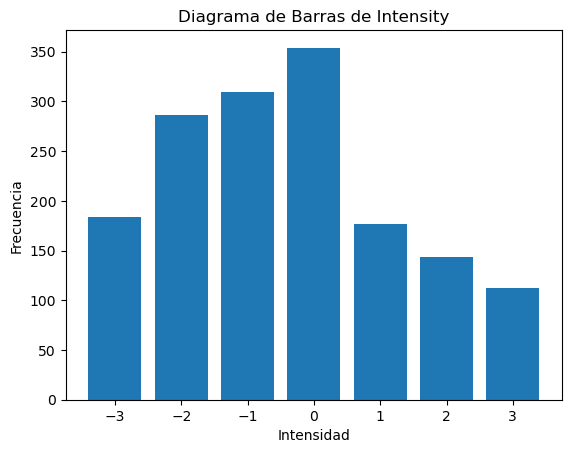

In [20]:
import matplotlib.pyplot as plt

# Contar las frecuencias de cada valor en la columna 'Intensity'
intensity_counts = train_set['Intensity'].value_counts().sort_index()

# Crear el gráfico de barras
plt.bar(intensity_counts.index, intensity_counts.values)

# Agregar un título al gráfico
plt.title('Diagrama de Barras de Intensity')

# Etiquetas para los ejes
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()


In [21]:
X_train = train_set['Tweet'].copy()
Y_train = train_set['Intensity'].copy()

X_test = test_set['Tweet'].copy()
Y_test = test_set['Intensity'].copy()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Se configura el vectorizador con N-gramas
vectorizer = CountVectorizer(ngram_range=(1, 3)) 
# Se aplica la vectorización a los datos de entrenamiento y prueba
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [23]:
# Crea y entrena un clasificador (en este caso, Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, Y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = classifier.predict(X_test_vectorized)

# Evalúa el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred)
classification_rep = classification_report(Y_test, y_pred)

# Imprime los resultados
print("Exactitud (Accuracy):", accuracy)
print("Reporte de clasificación:\n", classification_rep)

Exactitud (Accuracy): 0.2663755458515284
Reporte de clasificación:
               precision    recall  f1-score   support

          -3       0.50      0.19      0.28        21
          -2       0.27      0.30      0.28        44
          -1       0.18      0.21      0.19        42
           0       0.27      0.62      0.37        48
           1       0.50      0.03      0.06        31
           2       0.00      0.00      0.00        24
           3       0.67      0.21      0.32        19

    accuracy                           0.27       229
   macro avg       0.34      0.22      0.22       229
weighted avg       0.31      0.27      0.23       229



## Balanceo
- Del anterior modelo se puede apreciar que se tuvo un acurracy del 27%, es decir que no es capaz de predecir correctamente los nuevos casos que se le presentan, a continuacion se hará un balanceo de los datos con el proposito de observar si el acurracy mejora

In [24]:
import pandas as pd
import numpy as np

def balancear_dataframe(df, clase_col, cantidad_minima=None, random_seed=None):
    """
    Balancea un DataFrame seleccionando de manera aleatoria el mismo número de muestras para cada clase.

    Args:
        df (DataFrame): DataFrame de entrada.
        clase_col (str): Nombre de la columna que representa la clase.
        cantidad_minima (int, opcional): Cantidad mínima de muestras por clase. Si no se proporciona, se toma la cantidad mínima existente en el DataFrame.
        random_seed (int, opcional): Semilla para reproducir resultados aleatorios.

    Returns:
        DataFrame: DataFrame balanceado.
    """
    if cantidad_minima is None:
        cantidad_minima = df[clase_col].value_counts().min()

    # Función para muestrear aleatoriamente
    def muestrear_grupo(grupo):
        return grupo.sample(cantidad_minima, random_state=random_seed)

    # Aplicar la función de muestreo aleatorio a cada grupo (clase)
    df_balanceado = df.groupby(clase_col, group_keys=False).apply(muestrear_grupo)

    return df_balanceado

df_balanceado = balancear_dataframe(train_set, 'Intensity', random_seed=42)
df_balanceado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 172 to 1420
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      784 non-null    object
 1   Intensity  784 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 18.4+ KB


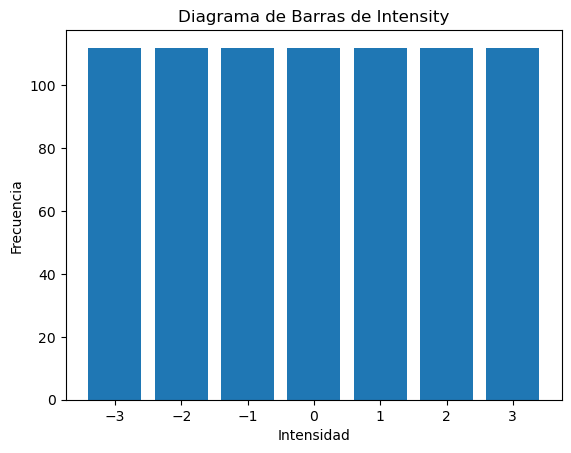

In [25]:
# Contar las frecuencias de cada valor en la columna 'Intensity'
intensity_counts = df_balanceado['Intensity'].value_counts().sort_index()

# Crear el gráfico de barras
plt.bar(intensity_counts.index, intensity_counts.values)

# Agregar un título al gráfico
plt.title('Diagrama de Barras de Intensity')

# Etiquetas para los ejes
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

In [26]:
X_train_balance = df_balanceado['Tweet'].copy()
Y_train_balance = df_balanceado['Intensity'].copy()

In [27]:
# Aplica la vectorización a los datos de entrenamiento
X_train_vectorized_balance = vectorizer.transform(X_train_balance)
X_train_vectorized_balance

<784x19951 sparse matrix of type '<class 'numpy.int64'>'
	with 17605 stored elements in Compressed Sparse Row format>

In [28]:
# Crea y entrena un clasificador (en este caso, Naive Bayes)
classifier_2 = MultinomialNB()
classifier_2.fit(X_train_vectorized_balance, Y_train_balance)

# Realiza predicciones en el conjunto de prueba
y_pred_2 = classifier_2.predict(X_test_vectorized)

# Evalúa el rendimiento del modelo
accuracy_2 = accuracy_score(Y_test, y_pred_2)
classification_rep_2 = classification_report(Y_test, y_pred_2)

# Imprime los resultados
print("Exactitud (Accuracy):", accuracy_2)
print("Reporte de clasificación:\n", classification_rep_2)

Exactitud (Accuracy): 0.24890829694323144
Reporte de clasificación:
               precision    recall  f1-score   support

          -3       0.20      0.48      0.29        21
          -2       0.29      0.27      0.28        44
          -1       0.28      0.26      0.27        42
           0       0.32      0.12      0.18        48
           1       0.18      0.19      0.18        31
           2       0.12      0.08      0.10        24
           3       0.33      0.53      0.41        19

    accuracy                           0.25       229
   macro avg       0.25      0.28      0.24       229
weighted avg       0.26      0.25      0.24       229



## Resultados

- Se observa que el acurracy no mejoró, al contrario disminuyó en 2% aproximadamente, pero éste acurracy se puede mejorar aumentando la cantidad de datos de entrenamiento y que el modelo sea mejor prediciendo casos nuevos que no se le presentaron en la fase de entrenamienta, y pues esto se sabe que es una limitacion del modelo a base de n-gramas y es que se require una gran cantidad de datos para un entrenamiento adecuado
